In [1]:
# 1. Imports and Setup
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
import random
import warnings
import logging
from itertools import product
from tqdm import tqdm

# Darts - Time Series Library
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import rmse, mape
from darts.utils.utils import ModelMode
from darts.models import (
    ExponentialSmoothing,
    AutoARIMA,
    Prophet,
    TiDEModel,
    NBEATSModel,
    TFTModel
)

# Foundation Models (optional)
try:
    from chronos import ChronosPipeline
    import torch
    CHRONOS_AVAILABLE = True
except ImportError:
    CHRONOS_AVAILABLE = False

try:
    from nixtla import NixtlaClient
    TIMEGPT_AVAILABLE = True
except ImportError:
    TIMEGPT_AVAILABLE = False

# Load API keys from external file (not tracked by git)
sys.path.insert(0, '..')
try:
    from api_keys import NIXTLA_API_KEY
except ImportError:
    NIXTLA_API_KEY = None
    print("Warning: api_keys.py not found. Copy api_keys.template.py to api_keys.py and add your keys.")

warnings.filterwarnings("ignore")
logging.getLogger("darts").setLevel(logging.WARNING)
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

print(f"Chronos: {'Available' if CHRONOS_AVAILABLE else 'Not installed'}")
print(f"TimeGPT: {'Available' if TIMEGPT_AVAILABLE else 'Not installed'}")

Chronos: Available
TimeGPT: Available


Dataset: ECB EUR/CZK Monthly
Train: 361 | Test: 24 | Seasonal period: 12


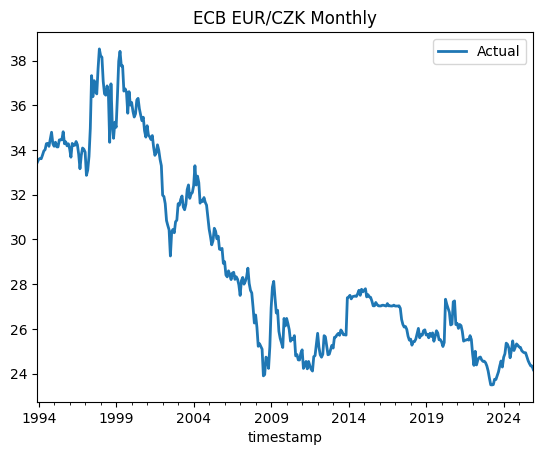

In [2]:
# 2. Data Loading and Preprocessing

# === DATASET CONFIGURATION ===
DATASET_CONFIG = {
    'file_path': '../datasets/ecb_eurczk_monthly.csv',
    'time_column': 'timestamp',
    'target_column': 'eur_czk',
    'frequency': 'MS',          # 'MS'=monthly, 'QS'=quarterly, 'YS'=yearly, 'H'=hourly, 'D'=daily
    'test_periods': 24,
    'seasonal_period': 12,      # 12=monthly, 4=quarterly, 1=yearly, 24=hourly, 7=daily
    'name': 'ECB EUR/CZK Monthly'
}

# === ALTERNATIVE DATASET CONFIGS (uncomment to use) ===
# DATASET_CONFIG = {
#     'file_path': '../datasets/wb_usa_real_gdp_yearly.csv',
#     'time_column': 'timestamp', 'target_column': 'real_gdp',
#     'frequency': 'YS', 'test_periods': 10, 'seasonal_period': 1,
#     'name': 'World Bank USA Real GDP Yearly'
# }

# DATASET_CONFIG = {
#     'file_path': '../datasets/fred_gpdic1_investments_quarterly.csv',
#     'time_column': 'timestamp', 'target_column': 'gpdic1',
#     'frequency': 'QS', 'test_periods': 8, 'seasonal_period': 4,
#     'name': 'FRED GPDIC1 Investments Quarterly'
# }

# DATASET_CONFIG = {
#     'file_path': '../datasets/m5_walmart_hobbies_daily.csv',
#     'time_column': 'timestamp', 'target_column': 'sales',
#     'frequency': 'D', 'test_periods': 28, 'seasonal_period': 7,
#     'name': 'M5 Walmart Hobbies Daily'
# }

# DATASET_CONFIG = {
#     'file_path': '../datasets/kaggle_btcusd_hourly.csv',
#     'time_column': 'timestamp', 'target_column': 'close',
#     'frequency': 'H', 'test_periods': 168, 'seasonal_period': 24,
#     'name': 'Kaggle BTC/USD Hourly'
# }

# === LOAD DATA ===
df = pd.read_csv(DATASET_CONFIG['file_path'])
df[DATASET_CONFIG['time_column']] = pd.to_datetime(df[DATASET_CONFIG['time_column']])
series = TimeSeries.from_dataframe(df, DATASET_CONFIG['time_column'], DATASET_CONFIG['target_column'])
series = series.astype(np.float32)

# Train/Test Split
freq = DATASET_CONFIG['frequency']
test_periods = DATASET_CONFIG['test_periods']
offset_map = {'MS': pd.DateOffset(months=test_periods), 'QS': pd.DateOffset(months=test_periods * 3),
              'YS': pd.DateOffset(years=test_periods), 'D': pd.DateOffset(days=test_periods),
              'H': pd.DateOffset(hours=test_periods)}
offset = offset_map.get(freq, pd.DateOffset(days=test_periods))

train, test = series.split_after(pd.Timestamp(series.end_time()) - offset)

# Scaler for DL models
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
series_scaled = scaler.transform(series)

print(f"Dataset: {DATASET_CONFIG['name']}")
print(f"Train: {len(train)} | Test: {len(test)} | Seasonal period: {DATASET_CONFIG['seasonal_period']}")

series.plot(label='Actual')
plt.title(DATASET_CONFIG['name'])
plt.show()

In [3]:
# 3. Evaluation Metrics and Logging

results = []

def log_result(model_name, rmse_val, mape_val, tuning_time, best_config_time, params=None, n_combinations=1):
    """Log model results with timing information."""
    results.append({
        'Model': model_name, 'RMSE': rmse_val, 'MAPE': mape_val,
        'Tuning Time (s)': tuning_time, 'Best Config Time (s)': best_config_time,
        'Combinations': n_combinations, 'Params': params
    })
    print(f"{model_name}: RMSE={rmse_val:.4f} | MAPE={mape_val:.2f}% | Time={tuning_time:.1f}s ({n_combinations} comb.)")

def get_results_df():
    return pd.DataFrame(results).sort_values(by='RMSE')

In [4]:
# 4. Hyperparameter Tuning (Grid/Random Search) with Cross-Validation

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

def grid_search_all(param_grid):
    """Generate all parameter combinations (full grid search)."""
    if not param_grid:
        return [{}]
    keys, values = list(param_grid.keys()), list(param_grid.values())
    return [dict(zip(keys, combo)) for combo in product(*values)]

def random_grid_search(param_grid, n_iter=5, seed=RANDOM_SEED):
    """Generate random parameter combinations with fixed seed."""
    rng = random.Random(seed)
    keys = list(param_grid.keys())
    if not keys:
        return [{}]
    
    combinations = [{key: rng.choice(param_grid[key]) for key in keys} for _ in range(n_iter)]
    seen = set()
    return [d for d in combinations if not (key := frozenset((k, str(v)) for k, v in d.items())) in seen and not seen.add(key)]

def evaluate_model(model_cls, params, series_train, series_val, is_dl=False, forecast_horizon=12, stride=1, scaler=None, original_series=None):
    """Evaluate model using rolling window cross-validation."""
    start_time = time.time()
    try:
        model = model_cls(**params)
        if is_dl:
            model.fit(series_train, verbose=False)
            backtest = model.historical_forecasts(series=series_train, start=0.7, forecast_horizon=forecast_horizon,
                                                   stride=stride, retrain=False, verbose=False, last_points_only=True)
        else:
            backtest = model.historical_forecasts(series=series_train, start=0.7, forecast_horizon=forecast_horizon,
                                                   stride=stride, retrain=True, verbose=False, last_points_only=True)
        
        if scaler:
            backtest = scaler.inverse_transform(backtest)
            actual = original_series if original_series else scaler.inverse_transform(series_train)
        else:
            actual = series_train

        return rmse(actual, backtest), mape(actual, backtest), time.time() - start_time
    except Exception as e:
        print(f"Error evaluating {getattr(model_cls, '__name__', str(model_cls))}: {e}")
        return float('inf'), float('inf'), 0

def run_tuning_and_eval(model_name, model_cls, param_grid, train_series, is_dl=False, 
                        n_iter=5, scaler=None, original_series=None, use_full_grid=False):
    """Run hyperparameter tuning and evaluation."""
    tuning_start = time.time()
    
    if not param_grid:
        rmse_val, mape_val, cfg_time = evaluate_model(model_cls, {}, train_series, None, is_dl=is_dl, scaler=scaler, original_series=original_series)
        if rmse_val != float('inf'):
            log_result(model_name, rmse_val, mape_val, time.time() - tuning_start, cfg_time, {}, 1)
        return {}
    
    combinations = grid_search_all(param_grid) if use_full_grid else random_grid_search(param_grid, n_iter=n_iter, seed=RANDOM_SEED)
    best_rmse, best_params, best_mape, best_cfg_time = float('inf'), None, 0, 0
    
    for params in tqdm(combinations, desc=model_name):
        rmse_val, mape_val, cfg_time = evaluate_model(model_cls, params, train_series, None, is_dl=is_dl, scaler=scaler, original_series=original_series)
        if rmse_val < best_rmse:
            best_rmse, best_params, best_mape, best_cfg_time = rmse_val, params, mape_val, cfg_time
    
    if best_params and best_rmse != float('inf'):
        log_result(model_name, best_rmse, best_mape, time.time() - tuning_start, best_cfg_time, best_params, len(combinations))
    return best_params

In [5]:
# 5. Statistical Models (Darts)

SEASONAL_PERIOD = DATASET_CONFIG['seasonal_period']

# Holt-Winters
hw_grid = {
    'seasonal_periods': [SEASONAL_PERIOD],
    'trend': [ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE, ModelMode.NONE],
    'seasonal': [ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE, ModelMode.NONE],
    'damped': [True, False]
}
run_tuning_and_eval("Holt-Winters", ExponentialSmoothing, hw_grid, train, use_full_grid=True)

# AutoARIMA
try:
    AutoARIMA()
    arima_grid = {
        'season_length': [SEASONAL_PERIOD],
        'seasonal': [True] if SEASONAL_PERIOD > 1 else [False],
        'max_p': [5], 'max_q': [5], 'max_P': [2], 'max_Q': [2], 'max_D': [1],
    }
    run_tuning_and_eval("AutoARIMA", AutoARIMA, arima_grid, train, use_full_grid=True)
except:
    print("AutoARIMA not available")

# Prophet
try:
    Prophet()
    prophet_grid = {
        'seasonality_mode': ['additive', 'multiplicative'],
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5]
    }
    run_tuning_and_eval("Prophet", Prophet, prophet_grid, train, use_full_grid=True)
except:
    print("Prophet not available")

Holt-Winters:  67%|██████▋   | 12/18 [01:09<00:34,  5.68s/it]

Error evaluating ExponentialSmoothing: Can only dampen the trend component


Holt-Winters:  78%|███████▊  | 14/18 [01:10<00:12,  3.23s/it]

Error evaluating ExponentialSmoothing: Can only dampen the trend component


Holt-Winters: 100%|██████████| 18/18 [01:11<00:00,  3.99s/it]


Error evaluating ExponentialSmoothing: Can only dampen the trend component
Holt-Winters: RMSE=0.8055 | MAPE=2.54% | Time=71.9s (18 comb.)


AutoARIMA: 100%|██████████| 1/1 [00:13<00:00, 13.21s/it]


AutoARIMA: RMSE=0.8981 | MAPE=2.87% | Time=13.2s (1 comb.)


Prophet: 100%|██████████| 8/8 [01:01<00:00,  7.69s/it]

Prophet: RMSE=1.2964 | MAPE=3.86% | Time=61.5s (8 comb.)


In [6]:
# 6. Deep Learning Models (Darts)

base_chunk = SEASONAL_PERIOD
common_dl_params = {
    'input_chunk_length': [base_chunk, base_chunk * 2],
    'output_chunk_length': [1, base_chunk // 2 if base_chunk > 2 else 1, base_chunk],
    'n_epochs': [10, 20],
    'random_state': [RANDOM_SEED]
}

# TiDE
tide_grid = {**common_dl_params, 'hidden_size': [64, 128], 'dropout': [0.1, 0.2],
             'num_encoder_layers': [1, 2], 'num_decoder_layers': [1, 2]}
run_tuning_and_eval("TiDE", TiDEModel, tide_grid, train_scaled, is_dl=True, 
                    n_iter=10, scaler=scaler, original_series=train)

# N-BEATS
nbeats_grid = {**common_dl_params, 'num_stacks': [10, 20], 'num_blocks': [1, 2], 'layer_widths': [128, 256]}
run_tuning_and_eval("N-BEATS", NBEATSModel, nbeats_grid, train_scaled, is_dl=True, 
                    n_iter=10, scaler=scaler, original_series=train)

# TFT
tft_grid = {**common_dl_params, 'hidden_size': [16, 32], 'lstm_layers': [1],
            'num_attention_heads': [4], 'dropout': [0.1], 'add_relative_index': [True]}
run_tuning_and_eval("TFT", TFTModel, tft_grid, train_scaled, is_dl=True, 
                    n_iter=10, scaler=scaler, original_series=train)

TiDE:   0%|          | 0/10 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TiDE:  10%|█         | 1/10 [00:01<00:16,  1.79s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TiDE:  20%|██        | 2/10 [00:02<00:09,  1.13s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TiDE:  30%|███    

TiDE: RMSE=0.7906 | MAPE=2.64% | Time=9.5s (10 comb.)


N-BEATS:   0%|          | 0/9 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
N-BEATS:  11%|█         | 1/9 [00:03<00:28,  3.61s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
N-BEATS:  22%|██▏       | 2/9 [00:07<00:24,  3.53s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
N-BEATS:  33

N-BEATS: RMSE=0.8535 | MAPE=2.80% | Time=46.5s (9 comb.)


TFT:   0%|          | 0/8 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TFT:  12%|█▎        | 1/8 [00:05<00:36,  5.19s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TFT:  25%|██▌       | 2/8 [00:07<00:20,  3.50s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TFT:  38%|███▊      | 3/

TFT: RMSE=2.3403 | MAPE=6.77% | Time=29.1s (8 comb.)


{'input_chunk_length': 12,
 'output_chunk_length': 1,
 'n_epochs': 20,
 'random_state': 42,
 'hidden_size': 16,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.1,
 'add_relative_index': True}

In [7]:
# 7. Foundation Models (Chronos, TimeGPT)

# Chronos (Amazon) - Local, no API key needed
if CHRONOS_AVAILABLE:
    try:
        start_time = time.time()
        pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-small",
            device_map="mps" if torch.backends.mps.is_available() else "cpu",
            torch_dtype=torch.float32
        )
        context = torch.tensor(train.values().flatten())
        forecast = pipeline.predict(context, prediction_length=len(test), num_samples=20)
        pred_values = forecast.median(dim=1).values.numpy().flatten()[:len(test)]
        pred_chronos = TimeSeries.from_times_and_values(times=test.time_index, values=pred_values)
        chronos_time = time.time() - start_time
        log_result("Chronos", rmse(test, pred_chronos), mape(test, pred_chronos), 
                   chronos_time, chronos_time, {'model': 'chronos-t5-small'}, 1)
    except Exception as e:
        print(f"Chronos error: {e}")

# TimeGPT (Nixtla) - Requires API key
if TIMEGPT_AVAILABLE and NIXTLA_API_KEY:
    try:
        start_time = time.time()
        nixtla_client = NixtlaClient(api_key=NIXTLA_API_KEY)
        try:
            train_df = train.pd_dataframe().reset_index()
        except AttributeError:
            train_df = pd.DataFrame({'ds': train.time_index, 'y': train.values().flatten()})
        train_df.columns = ['ds', 'y']
        forecast_df = nixtla_client.forecast(df=train_df, h=len(test), model='timegpt-1', freq=DATASET_CONFIG['frequency'])
        pred_timegpt = TimeSeries.from_times_and_values(times=test.time_index, values=forecast_df['TimeGPT'].values)
        timegpt_time = time.time() - start_time
        log_result("TimeGPT", rmse(test, pred_timegpt), mape(test, pred_timegpt),
                   timegpt_time, timegpt_time, {'model': 'timegpt-1'}, 1)
    except Exception as e:
        print(f"TimeGPT error: {e}")

`torch_dtype` is deprecated! Use `dtype` instead!
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...


Chronos: RMSE=0.6867 | MAPE=2.50% | Time=3.0s (1 comb.)


INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


TimeGPT: RMSE=0.7975 | MAPE=2.84% | Time=1.2s (1 comb.)


          Model      RMSE      MAPE  Tuning Time (s)  Best Config Time (s)  \
6       Chronos  0.686724  2.497415         3.034754              3.034754   
3          TiDE  0.790585  2.636333         9.499086              0.934554   
7       TimeGPT  0.797468  2.837711         1.164832              1.164832   
0  Holt-Winters  0.805530  2.544134        71.865828              1.759294   
4       N-BEATS  0.853470  2.803128        46.533903              3.600419   
1     AutoARIMA  0.898150  2.869939        13.211355             13.209884   
2       Prophet  1.296377  3.855752        61.529894              5.090595   
5           TFT  2.340295  6.765427        29.070045              5.191431   

   Combinations                                             Params  
6             1                      {'model': 'chronos-t5-small'}  
3            10  {'input_chunk_length': 24, 'output_chunk_lengt...  
7             1                             {'model': 'timegpt-1'}  
0            18  {'se

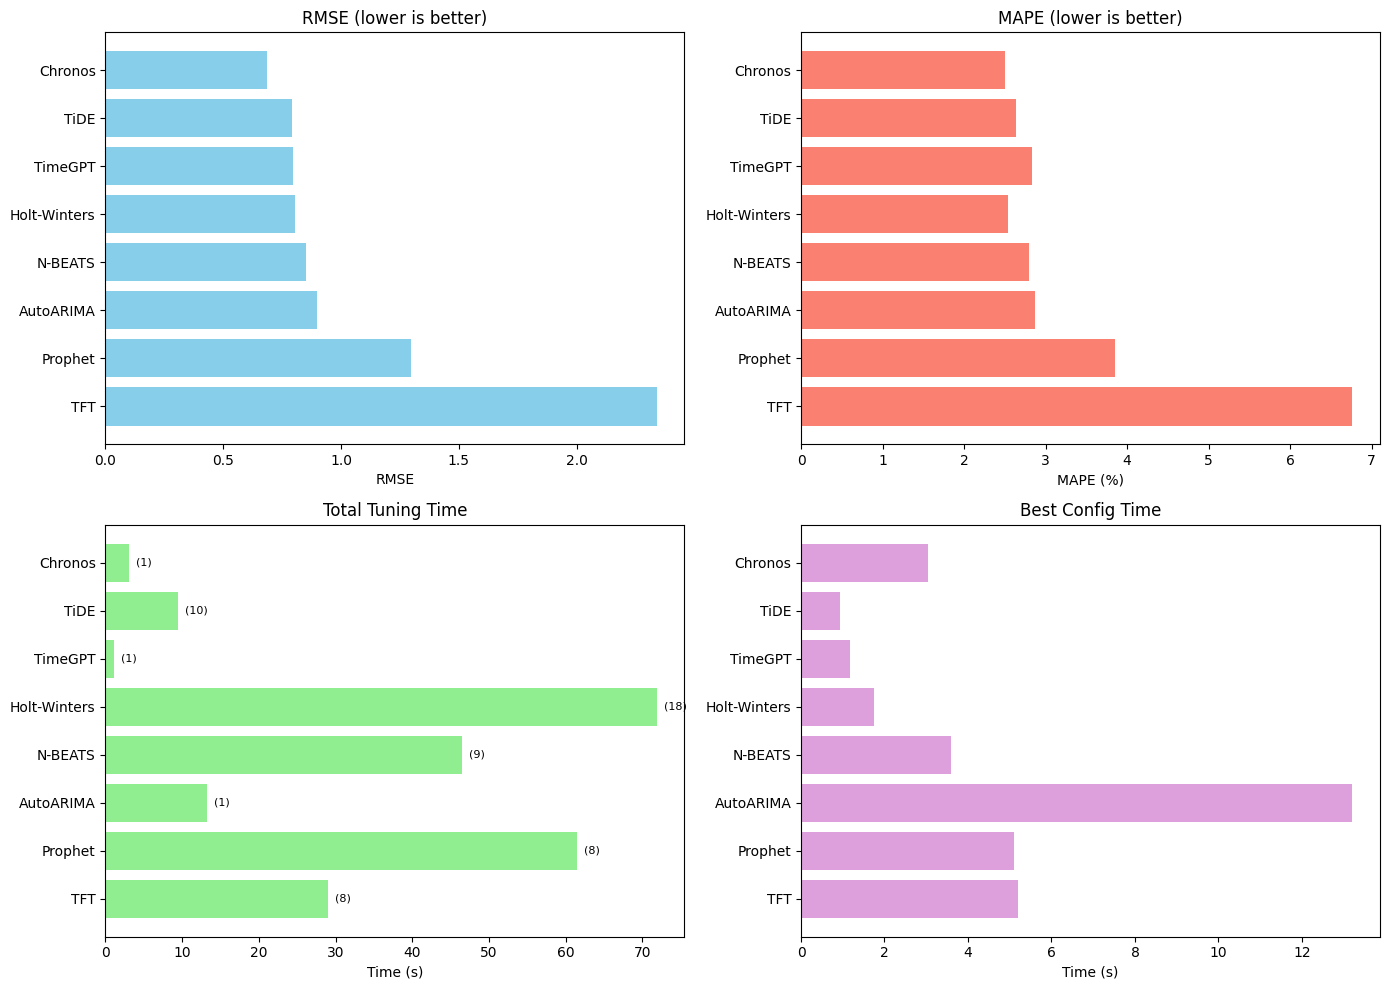


Best RMSE: Chronos (0.6867)
Best MAPE: Chronos (2.50%)
Fastest: TimeGPT (1.16s)


In [8]:
# 8. Results Comparison

results_df = get_results_df()
print(results_df)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].barh(results_df['Model'], results_df['RMSE'], color='skyblue')
axes[0, 0].set_xlabel('RMSE')
axes[0, 0].set_title('RMSE (lower is better)')
axes[0, 0].invert_yaxis()

axes[0, 1].barh(results_df['Model'], results_df['MAPE'], color='salmon')
axes[0, 1].set_xlabel('MAPE (%)')
axes[0, 1].set_title('MAPE (lower is better)')
axes[0, 1].invert_yaxis()

axes[1, 0].barh(results_df['Model'], results_df['Tuning Time (s)'], color='lightgreen')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_title('Total Tuning Time')
axes[1, 0].invert_yaxis()
for i, (model, combos) in enumerate(zip(results_df['Model'], results_df['Combinations'])):
    axes[1, 0].annotate(f'({combos})', xy=(results_df['Tuning Time (s)'].iloc[i], i), 
                        xytext=(5, 0), textcoords='offset points', va='center', fontsize=8)

axes[1, 1].barh(results_df['Model'], results_df['Best Config Time (s)'], color='plum')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_title('Best Config Time')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nBest RMSE: {results_df.iloc[0]['Model']} ({results_df.iloc[0]['RMSE']:.4f})")
print(f"Best MAPE: {results_df.sort_values('MAPE').iloc[0]['Model']} ({results_df.sort_values('MAPE').iloc[0]['MAPE']:.2f}%)")
print(f"Fastest: {results_df.sort_values('Tuning Time (s)').iloc[0]['Model']} ({results_df.sort_values('Tuning Time (s)').iloc[0]['Tuning Time (s)']:.2f}s)")

In [9]:
# 9. Final Predictions with Best and Fastest Models

def train_and_predict(model_name, params, is_dl):
    """Train model and return predictions."""
    if model_name == "Chronos" and CHRONOS_AVAILABLE:
        pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-small",
            device_map="mps" if torch.backends.mps.is_available() else "cpu", torch_dtype=torch.float32)
        context = torch.tensor(train.values().flatten())
        forecast = pipeline.predict(context, prediction_length=len(test), num_samples=20)
        return TimeSeries.from_times_and_values(times=test.time_index, 
                                                 values=forecast.median(dim=1).values.numpy().flatten()[:len(test)])
    
    if model_name == "TimeGPT" and TIMEGPT_AVAILABLE and NIXTLA_API_KEY:
        nixtla_client = NixtlaClient(api_key=NIXTLA_API_KEY)
        try:
            train_df = train.pd_dataframe().reset_index()
        except AttributeError:
            train_df = pd.DataFrame({'ds': train.time_index, 'y': train.values().flatten()})
        train_df.columns = ['ds', 'y']
        forecast_df = nixtla_client.forecast(df=train_df, h=len(test), model='timegpt-1', freq=DATASET_CONFIG['frequency'])
        return TimeSeries.from_times_and_values(times=test.time_index, values=forecast_df['TimeGPT'].values)
    
    model_map = {"Holt-Winters": ExponentialSmoothing, "AutoARIMA": AutoARIMA, "Prophet": Prophet,
                 "TiDE": TiDEModel, "N-BEATS": NBEATSModel, "TFT": TFTModel}
    if model_name not in model_map:
        return None
    
    model = model_map[model_name](**params)
    if is_dl:
        model.fit(train_scaled)
        return scaler.inverse_transform(model.predict(len(test)))
    model.fit(train)
    return model.predict(len(test))

final_predictions = {}

if not results_df.empty:
    # Best RMSE model
    best_row = results_df.iloc[0]
    is_dl_best = best_row['Model'] in ["TiDE", "N-BEATS", "TFT"]
    
    # Fastest model
    fastest_row = results_df.sort_values('Tuning Time (s)').iloc[0]
    is_dl_fast = fastest_row['Model'] in ["TiDE", "N-BEATS", "TFT"]
    
    print(f"Best RMSE: {best_row['Model']} | RMSE: {best_row['RMSE']:.4f} | MAPE: {best_row['MAPE']:.2f}%")
    print(f"Fastest: {fastest_row['Model']} | RMSE: {fastest_row['RMSE']:.4f} | Time: {fastest_row['Tuning Time (s)']:.1f}s")
    
    pred_best = train_and_predict(best_row['Model'], best_row['Params'], is_dl_best)
    if pred_best is not None:
        final_predictions['best_rmse'] = {
            'model': best_row['Model'], 'prediction': pred_best, 'params': best_row['Params'],
            'rmse': best_row['RMSE'], 'mape': best_row['MAPE'],
            'tuning_time': best_row['Tuning Time (s)'], 'combinations': best_row['Combinations']
        }
    
    if fastest_row['Model'] == best_row['Model']:
        final_predictions['fastest'] = final_predictions.get('best_rmse')
    else:
        pred_fast = train_and_predict(fastest_row['Model'], fastest_row['Params'], is_dl_fast)
        if pred_fast is not None:
            final_predictions['fastest'] = {
                'model': fastest_row['Model'], 'prediction': pred_fast, 'params': fastest_row['Params'],
                'rmse': fastest_row['RMSE'], 'mape': fastest_row['MAPE'],
                'tuning_time': fastest_row['Tuning Time (s)'], 'combinations': fastest_row['Combinations']
            }
    
    print("Predictions ready for visualization.")

Best RMSE: Chronos | RMSE: 0.6867 | MAPE: 2.50%
Fastest: TimeGPT | RMSE: 0.7975 | Time: 1.2s


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Predictions ready for visualization.


In [10]:
# 10. Interactive Visualization (Plotly)

def create_interactive_forecast_plot(train_series, test_series, predictions_dict, dataset_name, target_column=None):
    """Create interactive forecast comparison plot."""
    n_plots = len([k for k in ['best_rmse', 'fastest'] if predictions_dict.get(k)])
    if n_plots == 0:
        print("No predictions to display.")
        return None
    
    same_model = predictions_dict.get('best_rmse', {}).get('model') == predictions_dict.get('fastest', {}).get('model')
    if same_model:
        n_plots = 1
    
    # Create subplot titles with model names
    best_model = predictions_dict.get('best_rmse', {}).get('model', '')
    fast_model = predictions_dict.get('fastest', {}).get('model', '')
    
    subplot_titles = []
    if 'best_rmse' in predictions_dict:
        subplot_titles.append(f"<b>🏆 Best RMSE:</b> {best_model}")
    if not same_model and 'fastest' in predictions_dict:
        subplot_titles.append(f"<b>⚡ Fastest:</b> {fast_model}")
    
    fig = make_subplots(rows=1, cols=n_plots,
        horizontal_spacing=0.08)
    
    colors = {'train': '#1f77b4', 'test': '#2ca02c', 'pred1': '#d62728', 'pred2': '#ff7f0e'}
    
    def add_traces(pred_key, col, show_legend=True, show_forecast_legend_only=False):
        if pred_key not in predictions_dict:
            return
        pred_info = predictions_dict[pred_key]
        pred = pred_info['prediction']
        
        fig.add_trace(go.Scatter(x=train_series.time_index, y=train_series.values().flatten(),
            mode='lines', name='Train', line=dict(color=colors['train'], width=1.5),
            showlegend=show_legend and not show_forecast_legend_only, hovertemplate='<b>Train</b><br>Date: %{x}<br>Value: %{y:.4f}<extra></extra>'), row=1, col=col)
        
        fig.add_trace(go.Scatter(x=test_series.time_index, y=test_series.values().flatten(),
            mode='lines', name='Test (Actual)', line=dict(color=colors['test'], width=2),
            showlegend=show_legend and not show_forecast_legend_only, hovertemplate='<b>Actual</b><br>Date: %{x}<br>Value: %{y:.4f}<extra></extra>'), row=1, col=col)
        
        pred_color = colors['pred1'] if col == 1 else colors['pred2']
        fig.add_trace(go.Scatter(x=pred.time_index, y=pred.values().flatten(),
            mode='lines', name=f'Forecast ({pred_info["model"]})', line=dict(color=pred_color, width=2, dash='dash'),
            showlegend=show_legend, hovertemplate=f'<b>{pred_info["model"]}</b><br>Date: %{{x}}<br>Pred: %{{y:.4f}}<extra></extra>'), row=1, col=col)
    
    if 'best_rmse' in predictions_dict:
        add_traces('best_rmse', 1, show_legend=True)
    if not same_model and 'fastest' in predictions_dict:
        add_traces('fastest', 2, show_legend=True, show_forecast_legend_only=True)  # Only show forecast legend
    
    fig.update_layout(
        title=dict(text=f'<b>{dataset_name}</b> - Forecast Comparison', font=dict(size=16)),
        width=1700, height=500, hovermode='x unified',
        legend=dict(orientation='h', yanchor='bottom', y=1.08, xanchor='right', x=1),
        xaxis=dict(rangeslider=dict(visible=True, thickness=0.05), type='date', title='Date'),
        yaxis=dict(title=target_column if target_column else 'Value'))
    
    if n_plots == 2:
        fig.update_xaxes(rangeslider=dict(visible=True, thickness=0.05), type='date', title='Date', row=1, col=2)
        fig.update_yaxes(title=target_column if target_column else 'Value', row=1, col=2)
    
    annotations = []
    # Add subplot titles as annotations (more visible than subplot_titles)
    if 'best_rmse' in predictions_dict:
        info = predictions_dict['best_rmse']
        # Title above left graph
        annotations.append(dict(x=0.22 if n_plots == 2 else 0.5, y=1.02, xref='paper', yref='paper',
            text=f"<b>Best RMSE: {info['model']}</b>", showarrow=False, font=dict(size=13), xanchor='center'))
        # Metrics below left graph
        annotations.append(dict(x=0.22 if n_plots == 2 else 0.5, y=-0.18, xref='paper', yref='paper',
            text=f"RMSE: {info['rmse']:.4f} | MAPE: {info['mape']:.2f}% | Time: {info['tuning_time']:.1f}s", showarrow=False, font=dict(size=10), xanchor='center'))
    if not same_model and 'fastest' in predictions_dict:
        info = predictions_dict['fastest']
        # Title above right graph
        annotations.append(dict(x=0.78, y=1.02, xref='paper', yref='paper',
            text=f"<b>Fastest: {info['model']}</b>", showarrow=False, font=dict(size=13), xanchor='center'))
        # Metrics below right graph
        annotations.append(dict(x=0.78, y=-0.18, xref='paper', yref='paper',
            text=f"RMSE: {info['rmse']:.4f} | MAPE: {info['mape']:.2f}% | Time: {info['tuning_time']:.1f}s", showarrow=False, font=dict(size=10), xanchor='center'))
    
    fig.update_layout(annotations=annotations, margin=dict(b=100),
        updatemenus=[dict(type="buttons", direction="left", x=0.0, xanchor="left", y=1.15, yanchor="top",
            buttons=[dict(args=[{"xaxis.autorange": True, "xaxis2.autorange": True}], label="Reset", method="relayout"),
                     dict(args=[{"xaxis.range": [test_series.start_time(), test_series.end_time()],
                                "xaxis2.range": [test_series.start_time(), test_series.end_time()]}], 
                          label="Zoom Test", method="relayout")])])
    return fig

if 'final_predictions' in dir() and final_predictions:
    fig = create_interactive_forecast_plot(train, test, final_predictions, DATASET_CONFIG['name'], 
                                           target_column=DATASET_CONFIG['target_column'])
    if fig:
        fig.show()

In [11]:
# 11. All Models Comparison

def create_all_models_comparison(results_dataframe, dataset_name):
    """Create interactive comparison of all models."""
    fig = make_subplots(rows=2, cols=2,
        subplot_titles=['RMSE (lower is better)', 'MAPE % (lower is better)', 
                       'Total Tuning Time (s)', 'Best Config Time (s)'],
        vertical_spacing=0.15, horizontal_spacing=0.1)
    
    models = results_dataframe['Model'].tolist()
    
    fig.add_trace(go.Bar(y=models, x=results_dataframe['RMSE'], orientation='h',
        marker_color='skyblue', hovertemplate='<b>%{y}</b><br>RMSE: %{x:.4f}<extra></extra>'), row=1, col=1)
    
    fig.add_trace(go.Bar(y=models, x=results_dataframe['MAPE'], orientation='h',
        marker_color='salmon', hovertemplate='<b>%{y}</b><br>MAPE: %{x:.2f}%<extra></extra>'), row=1, col=2)
    
    fig.add_trace(go.Bar(y=models, x=results_dataframe['Tuning Time (s)'], orientation='h',
        marker_color='lightgreen', text=[f"({c})" for c in results_dataframe['Combinations']],
        textposition='outside', hovertemplate='<b>%{y}</b><br>Time: %{x:.2f}s<extra></extra>'), row=2, col=1)
    
    fig.add_trace(go.Bar(y=models, x=results_dataframe['Best Config Time (s)'], orientation='h',
        marker_color='plum', hovertemplate='<b>%{y}</b><br>Time: %{x:.2f}s<extra></extra>'), row=2, col=2)
    
    fig.update_layout(title=dict(text=f'<b>{dataset_name}</b> - All Models Comparison', font=dict(size=16)),
        width=1700, height=600, showlegend=False, margin=dict(l=120))
    
    for i in range(1, 3):
        for j in range(1, 3):
            fig.update_yaxes(autorange='reversed', row=i, col=j)
    return fig

if 'results_df' in dir() and not results_df.empty:
    fig_comparison = create_all_models_comparison(results_df, DATASET_CONFIG['name'])
    fig_comparison.show()